# Job change - classification models

Katarzyna Mocio, Marcin Miszkiel

The goal of this work is to apply various ML algorithms to build a model explaining whether a particular person is willing to change job based on the training sample and generate predictions for all observations from the test sample.

#### 1. Importing libraries 

In [2]:
import pandas  as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime as dt 
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score, precision_score, roc_auc_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgbm
import optuna
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100)

C:\Users\xrudz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Loading data, EDA and preprocessing

The dataset includes 12427 observations in the training sample and 3308 in the test sample and the following columns:

* **id** – unique observation identifier
* **gender** – gender of a person
* **age** – age of a person in years
* **education** – highest formal education level of a person attained so far
* **field_of_studies** – field of studies of a person
* **is_studying** – information whether a person is currently studying
* **county** – county code in which the person currently lives and works
* **relative_wage** – relative wage in the county (as percentage of country average)
* **years_since_job_change** – years since a person last changed the job
* **years_of_experience** – total number of years of professional experience of a person
* **hours_of_training** – total number of training hours completed by a person
* **is_certified** – does a person have any formal certificate of completed trainings
* **size_of_company** – size of a company in which a person currently works
* **typs_of_company** – type of a company in which a person currently works
* **transaction_amount_ratio** – ratio in total amount of transactions in the 4th quarter against the 1st quarter
* **willing_to_change_job** – is a person willing to change job (outcome variable, only in the training sample)

Let's load the dataset and see if there are any missing data. 

In [3]:
job_change = pd.read_csv('job_change_train.csv', index_col=None)
job_change.info()
job_change.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12427 entries, 0 to 12426
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      12427 non-null  int64  
 1   gender                  12427 non-null  object 
 2   age                     12427 non-null  int64  
 3   education               12427 non-null  object 
 4   field_of_studies        12427 non-null  object 
 5   is_studying             12427 non-null  object 
 6   county                  12427 non-null  object 
 7   relative_wage           12427 non-null  float64
 8   years_since_job_change  12427 non-null  object 
 9   years_of_experience     12427 non-null  object 
 10  hours_of_training       12427 non-null  int64  
 11  is_certified            12427 non-null  int64  
 12  size_of_company         12427 non-null  object 
 13  type_of_company         12427 non-null  object 
 14  willing_to_change_job   12427 non-null

,id,gender,age,education,field_of_studies,is_studying,county,relative_wage,years_since_job_change,years_of_experience,hours_of_training,is_certified,size_of_company,type_of_company,willing_to_change_job
0,1,Male,22,higher_BSc,science,no,county_118,162.84,1,2,18,1,<10,private_company,No
1,2,Male,27,higher_BSc,science,no,county_028,151.34,1,6,24,1,50-99,private_company,No
2,3,Male,38,higher_BSc,science,no,county_031,114.17,1,13,96,1,50-99,startup_with_funding,No
3,4,Unknown,47,higher_BSc,science,no,county_080,123.55,>4,>20,36,1,100-500,private_company,No
4,5,Male,28,higher_BSc,science,no,county_118,162.84,1,5,106,1,1000-4999,private_company,No


In [4]:
job_change.describe()

,id,age,relative_wage,hours_of_training,is_certified
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,6214.000000,32.844130,146.556512,65.079182,0.720206
std,3587.510232,8.164951,21.963880,60.403599,0.448916
min,1.000000,20.000000,79.300000,1.000000,0.000000
25%,3107.500000,26.000000,130.630000,23.000000,0.000000
50%,6214.000000,31.000000,159.830000,47.000000,1.000000
75%,9320.500000,38.000000,162.840000,88.000000,1.000000
max,12427.000000,50.000000,167.970000,336.000000,1.000000


In [78]:
for i in job_change.columns:
    print(job_change[i].unique())

[    1     2     3 ... 12425 12426 12427]
['Male' 'Unknown' 'Female' 'Other']
[22 27 38 47 28 25 32 23 24 26 42 48 35 34 30 50 39 29 49 36 40 33 21 46
 44 20 31 45 37 43 41]
['higher_BSc' 'secondary' 'higher_MSc' 'Phd' 'primary' 'no_information']
['science' 'no_information' 'other' 'humanities' 'business' 'arts']
['no' 'full_time' 'part_time' 'no_information']
['county_118' 'county_028' 'county_031' 'county_080' 'county_059'
 'county_117' 'county_074' 'county_049' 'county_040' 'county_018'
 'county_110' 'county_022' 'county_025' 'county_075' 'county_119'
 'county_092' 'county_041' 'county_121' 'county_108' 'county_053'
 'county_006' 'county_020' 'county_077' 'county_019' 'county_042'
 'county_081' 'county_038' 'county_029' 'county_112' 'county_086'
 'county_001' 'county_068' 'county_021' 'county_116' 'county_013'
 'county_093' 'county_024' 'county_102' 'county_099' 'county_058'
 'county_062' 'county_032' 'county_046' 'county_123' 'county_120'
 'county_045' 'county_076' 'county_030' 'co

In [79]:
job_change = job_change.replace('unknown', np.nan)
job_change = job_change.replace('Unknown', np.nan)
job_change = job_change.replace('no_information', np.nan)
# Przyjmuję, że job_change to DataFrame wcześniej zdefiniowany
kategorie = ['gender', 'education', 'field_of_studies', 'years_since_job_change', 'is_studying', 'county', 
             'size_of_company', 'type_of_company', 'willing_to_change_job']
for col in kategorie:
    job_change[col] = job_change[col].astype('category')

#Przykład zamiany wartości specjalnych
job_change['years_since_job_change'] = job_change['years_since_job_change'].replace('>4', '5')
job_change['years_since_job_change'] = job_change['years_since_job_change'].replace('never_changed', '6')

# Konwersja kolumny na numeryczną
job_change['years_since_job_change'] = pd.to_numeric(job_change['years_since_job_change'], errors='coerce')

# Definicja kategorii i zakresów
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, float('inf')]
labels1 = ['1', '2', '3', '4', '>4', 'never_changed']
job_change['years_since_job_change'] = pd.cut(job_change['years_since_job_change'], bins=bins, labels=labels1, right=False)
job_change['years_since_job_change'] = pd.Categorical(job_change['years_since_job_change'], categories=labels1, ordered=True)

# Zamiana wartości na numeryczne
job_change['years_of_experience'] = job_change['years_of_experience'].replace('>20', '21').replace('<1', '0')
job_change['years_of_experience'] = pd.to_numeric(job_change['years_of_experience'], errors='coerce')

# Definiowanie kategorii i zakresów
bins = [-0.5, 0.5, 5.5, 10.5, 15.5, 20.5, float('inf')]
labels2 = ['<1', '1-5', '6-10', '11-15', '16-20', '>20']
job_change['years_of_experience'] = pd.cut(job_change['years_of_experience'], bins=bins, labels=labels2, right=False)
job_change['years_of_experience'] = pd.Categorical(job_change['years_of_experience'], categories=labels2, ordered=True)

# Konwersja innych kolumn na odpowiednie typy
job_change['is_certified'] = job_change['is_certified'].astype(bool)
job_change['willing_to_change_job'] = job_change['willing_to_change_job'].astype(bool)

# Ustawienie indeksu
job_change.set_index('id', inplace=True)

# Informacja o danych
print(job_change.info())



<class 'pandas.core.frame.DataFrame'>
Index: 12427 entries, 1 to 12427
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   gender                  9464 non-null   category
 1   age                     12427 non-null  int64   
 2   education               12132 non-null  category
 3   field_of_studies        10592 non-null  category
 4   is_studying             12168 non-null  category
 5   county                  12427 non-null  category
 6   relative_wage           12427 non-null  float64 
 7   years_since_job_change  12139 non-null  category
 8   years_of_experience     12387 non-null  category
 9   hours_of_training       12427 non-null  int64   
 10  is_certified            12427 non-null  bool    
 11  size_of_company         8577 non-null   category
 12  type_of_company         8432 non-null   category
 13  willing_to_change_job   12427 non-null  bool    
dtypes: bool(2), category(9), fl

In [80]:
job_change.describe()

,age,relative_wage,hours_of_training
count,12427.000000,12427.000000,12427.000000
mean,32.844130,146.556512,65.079182
std,8.164951,21.963880,60.403599
min,20.000000,79.300000,1.000000
25%,26.000000,130.630000,23.000000
50%,31.000000,159.830000,47.000000
75%,38.000000,162.840000,88.000000
max,50.000000,167.970000,336.000000


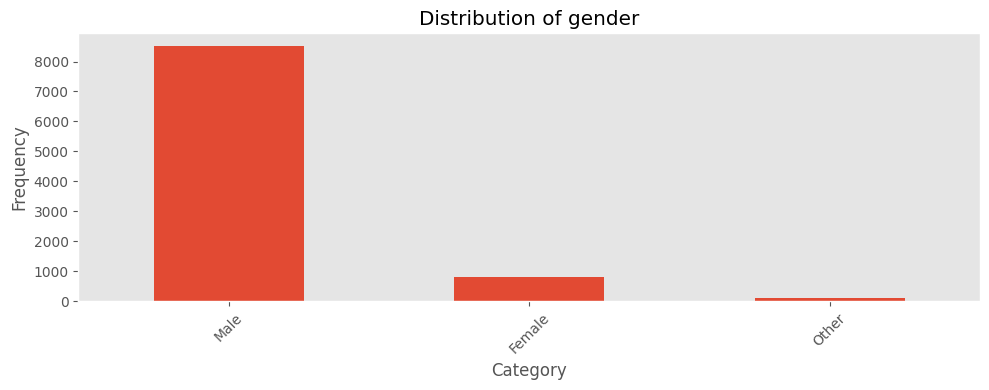

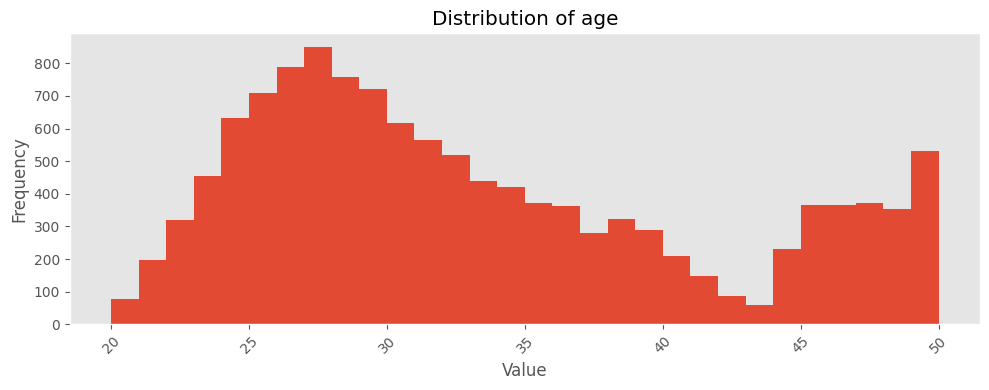

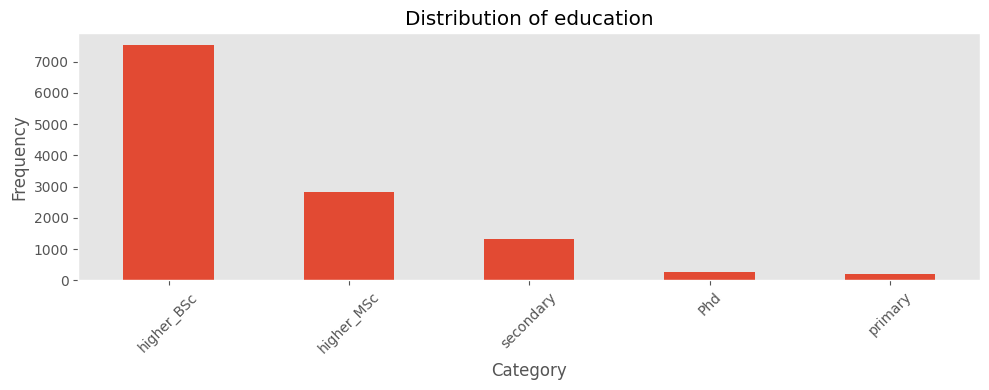

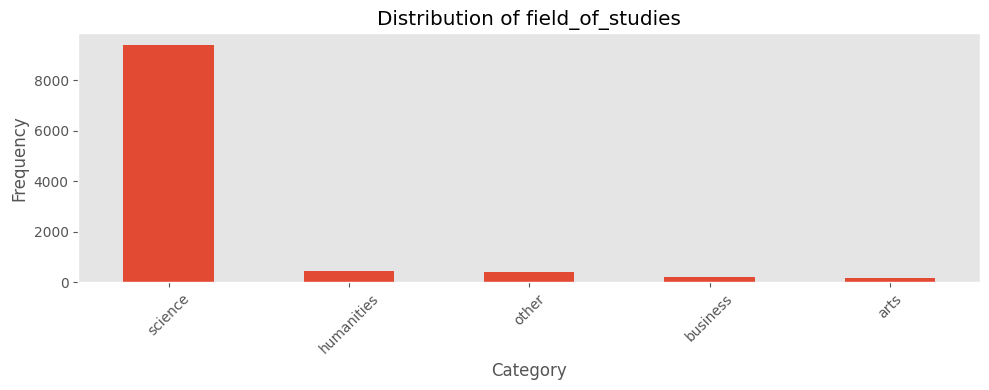

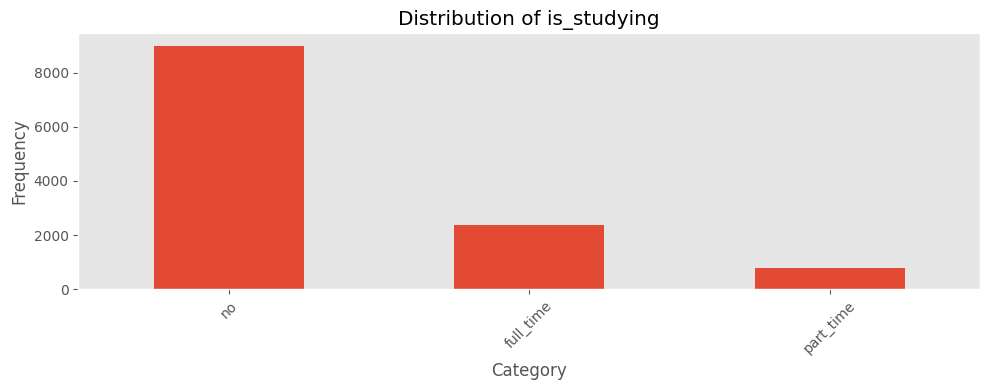

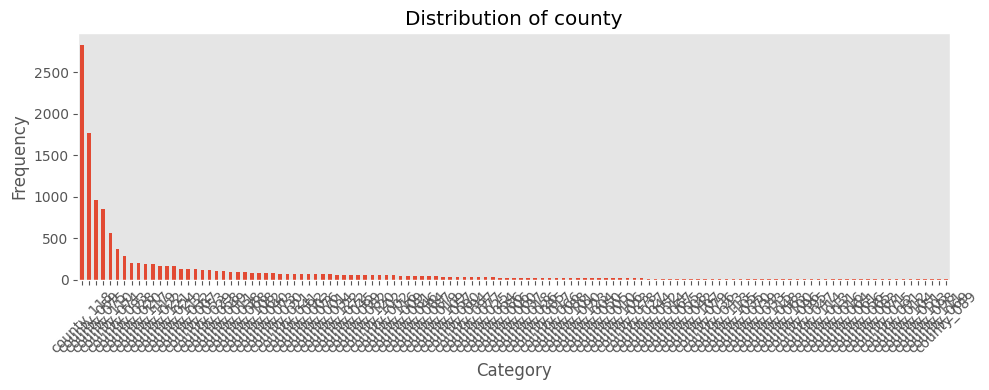

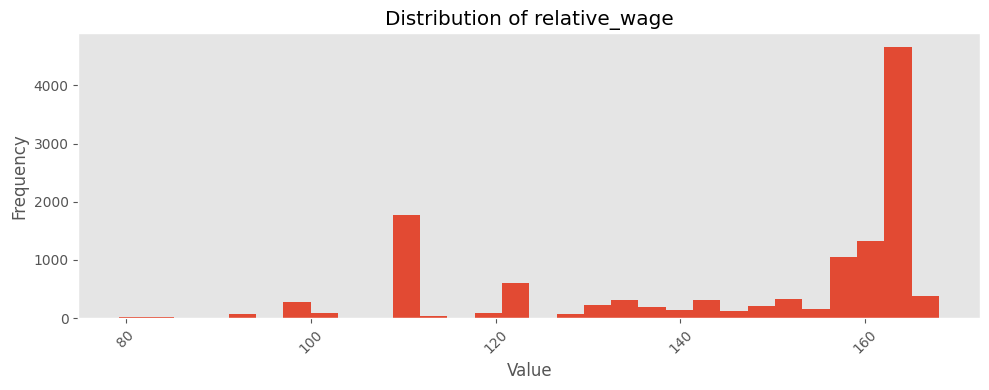

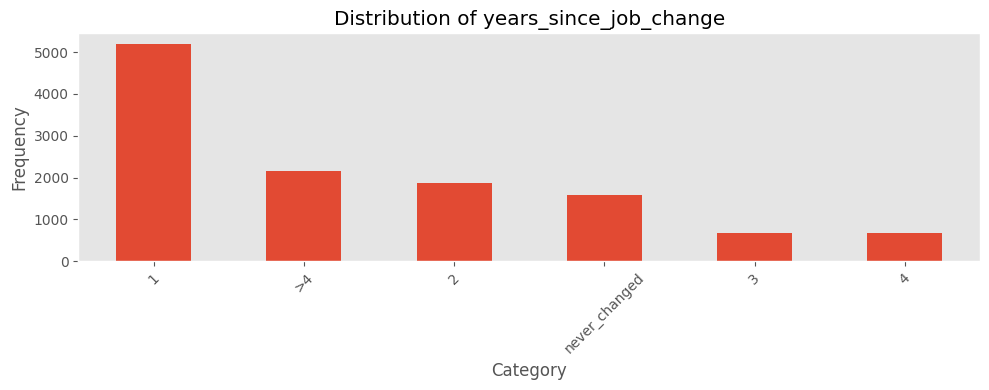

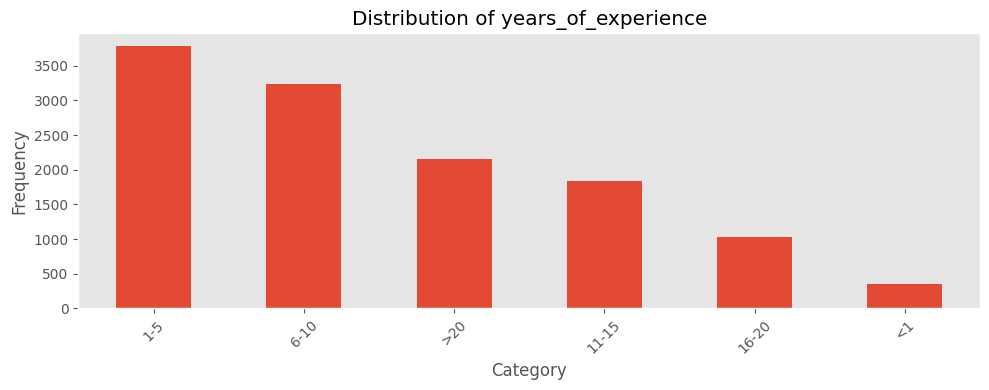

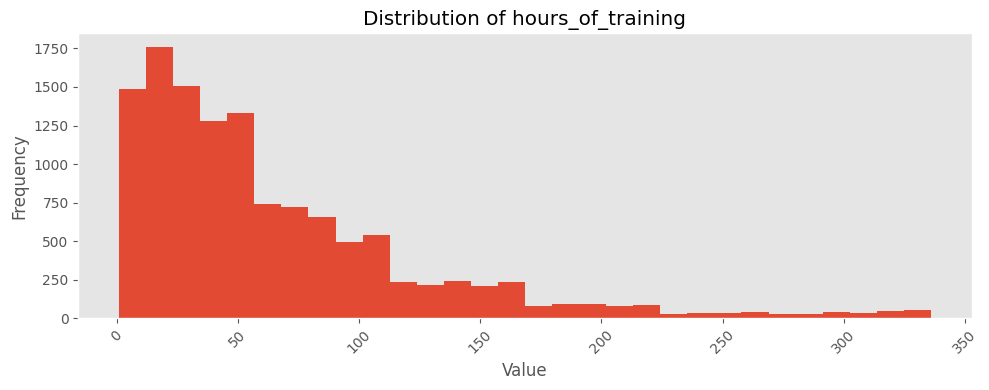

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

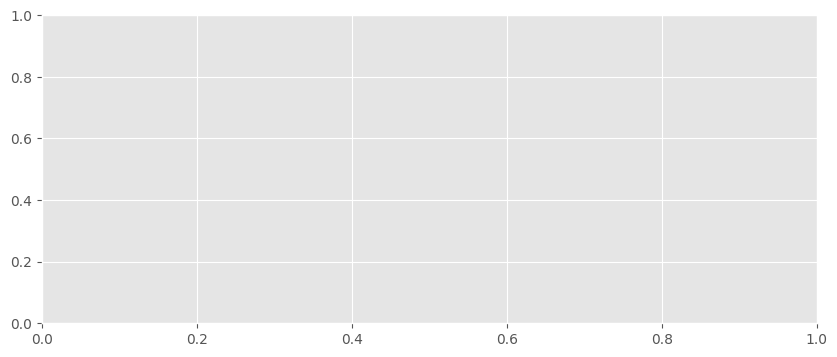

In [82]:
# Generate histograms or bar charts for each column
for column in job_change.columns:
    plt.figure(figsize=(10, 4))
    if pd.api.types.is_numeric_dtype(job_change[column]):
        # For numeric data, use a histogram
        job_change[column].dropna().hist(bins=30)
        plt.xlabel('Value')
    elif pd.api.types.is_categorical_dtype(job_change[column]):
        # For categorical data, use a bar chart
        job_change[column].value_counts().plot(kind='bar')
        plt.xlabel('Category')
    elif pd.api.types.is_bool_dtype(job_change[column]):
        # For boolean data, count the True/False values and use a bar chart
        job_change[column].value_counts().plot(kind='bar')
        plt.xlabel('Boolean Value')
    else:
        continue  # If the data type is not covered, skip it

    plt.title(f'Distribution of {column}')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

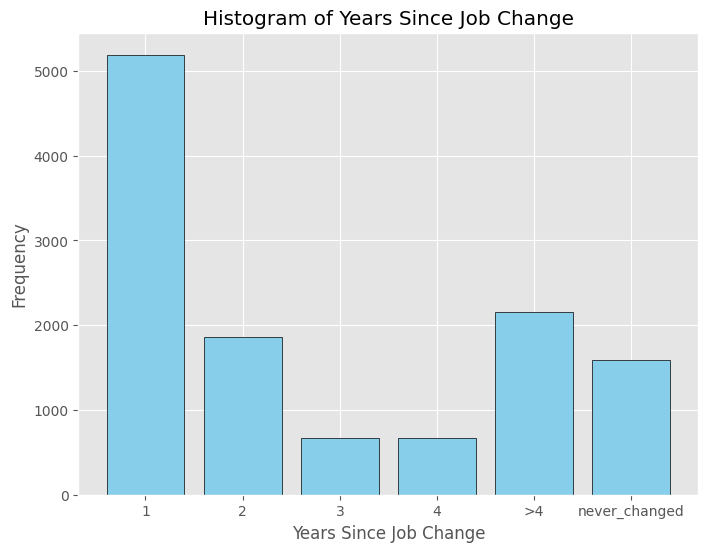

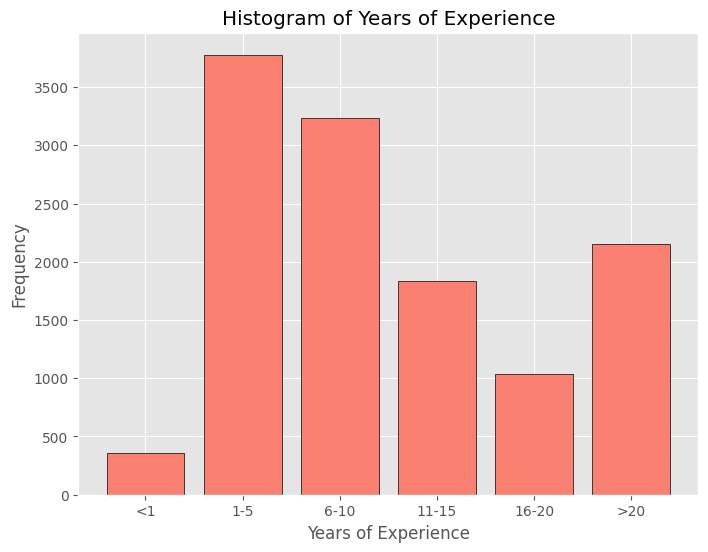

In [62]:
plt.style.use('ggplot')

# Obliczanie liczności dla każdej kategorii
category_counts = job_change['years_since_job_change'].value_counts().reindex(labels1)

# Tworzenie wykresu słupkowego dla lat od zmiany pracy
plt.figure(figsize=(8, 6))
plt.bar(category_counts.index, category_counts, color='skyblue', edgecolor='black')
plt.title('Histogram of Years Since Job Change')
plt.xlabel('Years Since Job Change')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Obliczanie liczności dla każdej kategorii
category_counts = job_change['years_of_experience'].value_counts().reindex(labels2)

# Tworzenie wykresu słupkowego dla lat doświadczenia
plt.figure(figsize=(8, 6))
plt.bar(category_counts.index, category_counts, color='salmon', edgecolor='black')
plt.title('Histogram of Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

As you can see the dataset is complete with no missing data. <br>

Now let's create boxplots for these variables to see if there are any outliers.


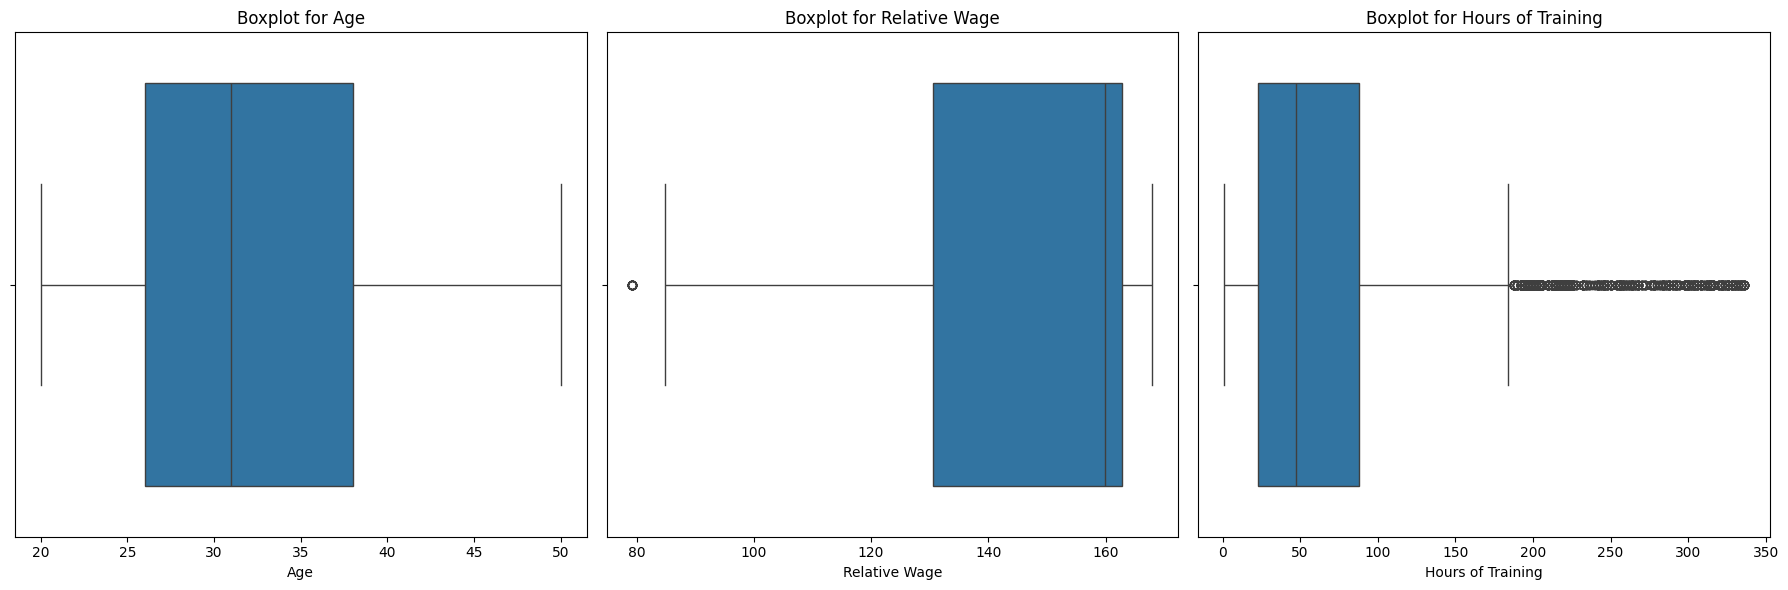

In [32]:
plt.figure(figsize=(18, 6))

# boxplot age
plt.subplot(1, 3, 1)
sns.boxplot(x=job_change['age'])
plt.title('Boxplot for Age')
plt.xlabel('Age')

# boxplot relative_wage
plt.subplot(1, 3, 2)
sns.boxplot(x=job_change['relative_wage'])
plt.title('Boxplot for Relative Wage')
plt.xlabel('Relative Wage')

# boxplot hours_of_training
plt.subplot(1, 3, 3)
sns.boxplot(x=job_change['hours_of_training'])
plt.title('Boxplot for Hours of Training')
plt.xlabel('Hours of Training')

plt.tight_layout()
plt.show()

In [33]:
distinct_value_counts_relative_wage = job_change['relative_wage'].value_counts().sort_index()

print(distinct_value_counts_relative_wage)

Q1 = job_change['relative_wage'].quantile(0.25)
Q3 = job_change['relative_wage'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = round(Q1 - 1.5 * IQR, 2)

print(lower_bound)

relative_wage
79.30      14
84.78      17
86.20       3
87.26       7
90.62       3
         ... 
163.55    200
163.72    118
163.90    854
166.20    330
167.97     51
Name: count, Length: 93, dtype: int64
82.31


In [34]:
job_change.loc[job_change['relative_wage'] == 79.30, 'relative_wage'] = lower_bound

distinct_value_counts_relative_wage = job_change['relative_wage'].value_counts().sort_index()

print(distinct_value_counts_relative_wage)

relative_wage
82.31      14
84.78      17
86.20       3
87.26       7
90.62       3
         ... 
163.55    200
163.72    118
163.90    854
166.20    330
167.97     51
Name: count, Length: 93, dtype: int64


In [35]:
distinct_value_counts_hours_of_training = job_change['hours_of_training'].value_counts().sort_index()

print(distinct_value_counts_hours_of_training)

hours_of_training
1        6
2       66
3       83
4      149
5       65
      ... 
328      9
330      7
332      7
334      9
336      8
Name: count, Length: 241, dtype: int64


As we can see Age does not has any outliers. Relative Wage has 1 value under the lower bound and there are 14 observations. So we have 14 potential outliers out of 12427 observations. To minimize influence of the outliers we replaced this value with the lower bound value of Relative Wage. On the other hand Hours of training variable has much more outliers. But it's hard to say whether they are outliers for sure. We can observe quite big number of observations over the upper bound value and they are continuously along variable's domain. The values have a theoretical sense and might be correct. We decided to keep these observations with their original value of hours of training.

In [44]:
for i in job_change.columns:
    distinct_value_counts = job_change[i].value_counts().sort_index()
    print(distinct_value_counts)
    print()

id
1        1
2        1
3        1
4        1
5        1
        ..
12423    1
12424    1
12425    1
12426    1
12427    1
Name: count, Length: 12427, dtype: int64

gender
Female      826
Male       8515
Other       123
Unknown    2963
Name: count, dtype: int64

age
20     78
21    197
22    319
23    456
24    632
25    710
26    787
27    849
28    759
29    722
30    618
31    566
32    519
33    439
34    421
35    373
36    363
37    281
38    323
39    289
40    211
41    149
42     87
43     59
44    230
45    365
46    367
47    373
48    353
49    344
50    188
Name: count, dtype: int64

education
Phd                257
higher_BSc        7528
higher_MSc        2831
no_information     295
primary            196
secondary         1320
Name: count, dtype: int64

field_of_studies
arts               166
business           213
humanities         445
no_information    1835
other              388
science           9380
Name: count, dtype: int64

is_studying
full_time         2378
no 

### Exploanatory Data Analysis

Let's start by creating a correlation matrix. <br>None of the variables are highly correlated with each other (assumed threshold >|0.7|). <br>In particular, it is good information that the predicted variable has only very weak correlation coefficients. 

In [36]:
plt.figure(figsize=(16, 6))
job_change['cocaine_0_1'] = np.where(job_change['consumption_cocaine_last_month'] == 'Yes', 1,0)
heatmap = sns.heatmap(job_change.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=11)

KeyError: 'consumption_cocaine_last_month'

<Figure size 1600x600 with 0 Axes>